In [189]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from sklearn.manifold import MDS
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
settlingTime = 2 ** 12
tlen = 2 ** 8
end = 2**11.5 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 2

t = np.linspace(0, end, num=tlen)

In [199]:
## Drivers ##

b1 = lambda t: 2.5 + 5 * t / end
#rho = lambda t : 28 # + 10 * t / end
#sigma = lambda t : 10 # + 10 * t / end
#beta = lambda t : 5.0 / 3.0 + 3*t/end

In [200]:
## Time Series Generation ##
x0 = np.multiply(np.array([1,0.5,7]),rand.random(3))
Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]

## Add Noise ##
noise_magnitude = 0.0
# Xr += rand.random((Xr.shape[0],1)) * np.ptp(Xr) * noise_magnitude

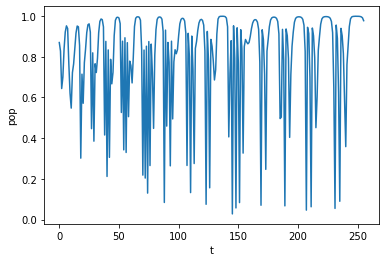

In [201]:
plotTS(Xr)

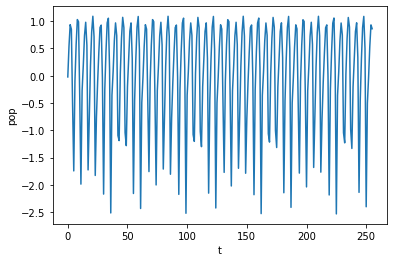

E=2
E=3
E=4
E=5
E=6
E=7
E=8
E=9
E=10
E=11
E=12


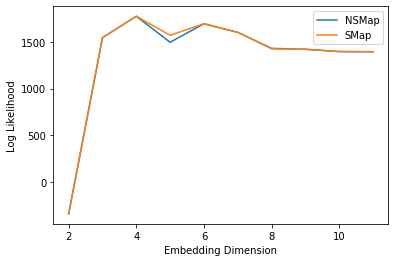

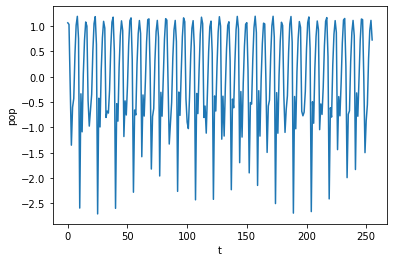

E=2
E=3
E=4
E=5
E=6
E=7
E=8
E=9
E=10
E=11
E=12


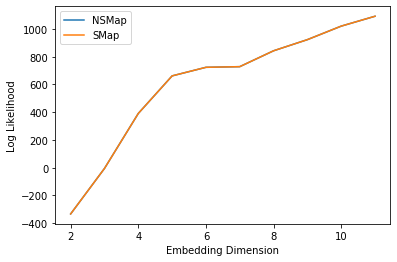

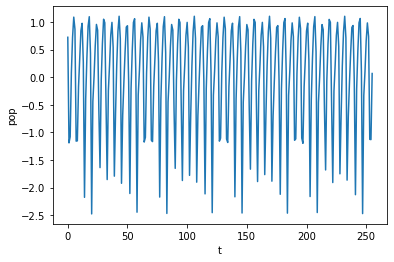

E=2
E=3
E=4
E=5
E=6
E=7
E=8
E=9
E=10
E=11
E=12


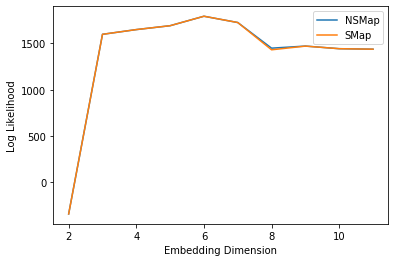

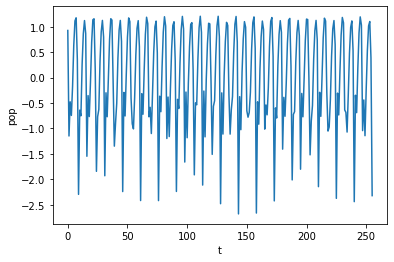

E=2
E=3
E=4
E=5
E=6
E=7
E=8
E=9
E=10
E=11
E=12


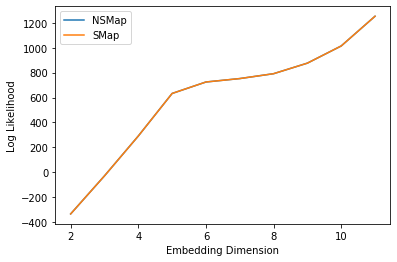

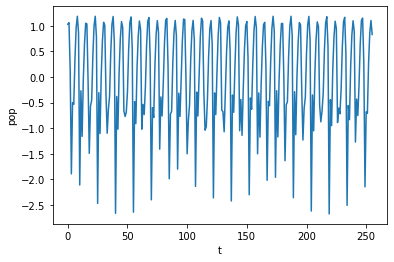

E=2
E=3
E=4
E=5
E=6
E=7
E=8
E=9
E=10
E=11
E=12


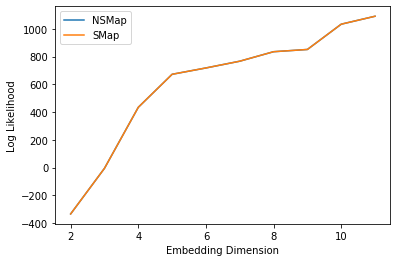

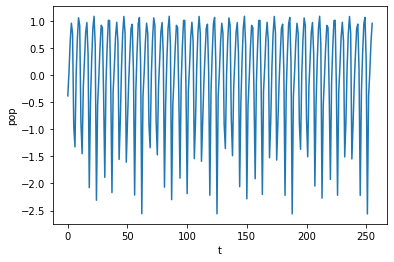

E=2
E=3
E=4
E=5
E=6


In [ ]:
# Final data will be
# Nonstat Rate(0,1)|theta|delta|err(l1o)|err(seq)|dof

resolution = 10
horizon = 1
num_repetitions = 10
noise_magnitude = 0.0
maxLags = 10

# [rate, lamdbaLR, stationary probability]
# column 0 is nonstationarity rate,
# columns 1-10 are deltas for each E
# columns 11-20 are likelihoods for NSMap
# columns 21-30 are likelihoods for SMap

table = np.zeros((resolution*num_repetitions, 31))

x0 = np.array([0.1,0.4,9]) 
for r in range(resolution):
    rate = float(r)/resolution
    b1 = lambda t: 2.5 + rate * 4 * t / end
    
    for i in range(num_repetitions):
        x0 = np.array([0.1,0.4,9]) + np.multiply(np.array([1,0.5,7]),rand.random(3))
        Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]

        plotTS(Xr)
        
        T2 = StationaryProbability(Xr, t, horizon, maxLags)
        
        if np.sum(T2[:,4]) == 0:
            delta_agg = 0
        else:
            delta_agg = np.average(T2[:,0] - T2[:,1], weights=T2[:,4])
        
        table[r*num_repetitions+i] = np.hstack([np.array([rate]),T2[:,4], T2[:,0], T2[:,1]])
        
        # dof_difference = np.sum(T2[:,2] - T2[:,3])
        # stationary_probability = chisig(lambdaLR, dof_difference)
        
        # table[r*num_repetitions+i] = np.array([rate, lambdaLR, stationary_probability])

In [177]:
# but first, save the data

# np.save("nonstationarity_rate_vs_delta_and_log_likelihood_NS_S_6_30_2022", table)

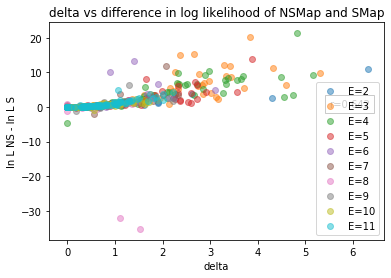

In [178]:
# First question: is delta correlated with the log likelihood difference?

deltas = table[:,1:11]
nonstationarity_areas = (table[:,11:21] - table[:,21:])

fig, ax = plt.subplots(1)

ax.set_title("delta vs difference in log likelihood of NSMap and SMap")
ax.set_xlabel("delta")
ax.set_ylabel("ln L NS - ln L S")
for E in range(2,2+maxLags):
    ax.scatter(deltas[:,E-2], nonstationarity_areas[:,E-2], alpha=0.5, label=f"E={E}")
ax.text(5.5,0,f"r={np.corrcoef(deltas.flatten(),nonstationarity_areas.flatten())[1,0]:.3f}",bbox=dict(facecolor="white"))
ax.legend()
plt.show()

ValueError: x and y must be the same size

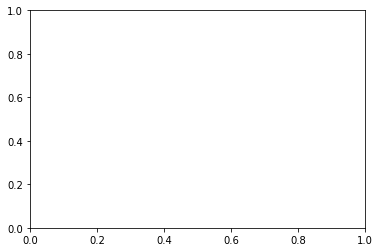

In [179]:
# I want to see if there is a relationship between E and the delta we optimze to
fig, ax = plt.subplots(1)

for E in range(2,2+maxLags):
    ax.scatter(np.ones(40)*E, deltas[:,E-2])

ax.set_ylabel("delta")
ax.set_xlabel("Embedding Dimension")
    
plt.show()

In [160]:
deltas.shape

(40, 10)

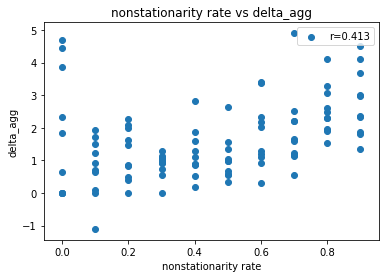

In [180]:
deltas = table[:,1:11]
weights = table[:,11:21] - table[:,21:]

deltas_agg = np.sum(deltas * weights, axis=1) * np.reciprocal(np.sum(weights,axis=1), where=np.sum(weights,axis=1)!=0)

fig, ax = plt.subplots(1)

ax.set_title("nonstationarity rate vs delta_agg")
ax.set_xlabel("nonstationarity rate")
ax.set_ylabel("delta_agg")
ax.scatter(table[:,0], deltas_agg, label=f"r={np.corrcoef(table[:,0],deltas_agg)[1,0]:.3f}")
ax.legend()
plt.show()

In [147]:
deltas_agg = np.sum(deltas * np.exp(weights), axis=1) / np.sum(np.exp(weights), axis=1)

In [148]:
deltas_kagg = np.add(np.zeros(40),np.sum(table[:,1:11] * weights, axis=1) / np.sum(weights, axis=1), where=(np.sum(weights, axis=1)!=0))

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [153]:
deltas_agg

array([6.12090728e-01, 3.56340130e-01, 3.36939888e-03, 1.29263469e-01,
       6.14144893e+00, 0.00000000e+00, 6.16424304e-03, 1.31364417e+00,
       1.06576873e+00, 2.59612735e-01, 6.55084006e-01, 2.17874973e-01,
       4.25116740e-01, 1.83739010e-01, 0.00000000e+00, 4.06722936e-01,
       3.20445739e+00, 2.50188762e-01, 2.54128203e+00, 1.48943570e+00,
       2.33461846e+00, 1.50451016e+00, 1.39048007e+00, 1.24066876e+00,
       1.03838493e+00, 1.90450884e+00, 2.18634822e+00, 1.17747089e+00,
       7.74650366e-01, 1.74899546e-01, 2.67042378e+00, 1.93832634e+00,
       9.69222180e-01, 2.22301988e+00, 2.28300034e-01, 1.73445844e+00,
       4.68709686e-01, 3.19550048e+00, 1.64583758e+00, 1.64934894e+00])

In [154]:
deltas_kagg

array([0.88606838, 1.08409731, 0.03349358, 0.63652685, 4.41954743,
       0.        , 0.00792529, 1.56577124, 1.38912183, 0.7265176 ,
       0.99758403, 0.46876691, 0.90342181, 0.66590164, 0.        ,
       0.75916346, 3.06246968, 0.53501208, 2.19258634, 1.52638889,
       2.00874262, 1.5378863 , 1.51046994, 1.37907881, 1.32435452,
       1.98572298, 2.02510106, 1.4021218 , 0.98947585, 0.69710698,
       2.51581656, 1.97740572, 1.17247598, 2.07756223, 0.98107981,
       1.68032303, 0.65169209, 2.95806014, 1.61827938, 1.66497581])

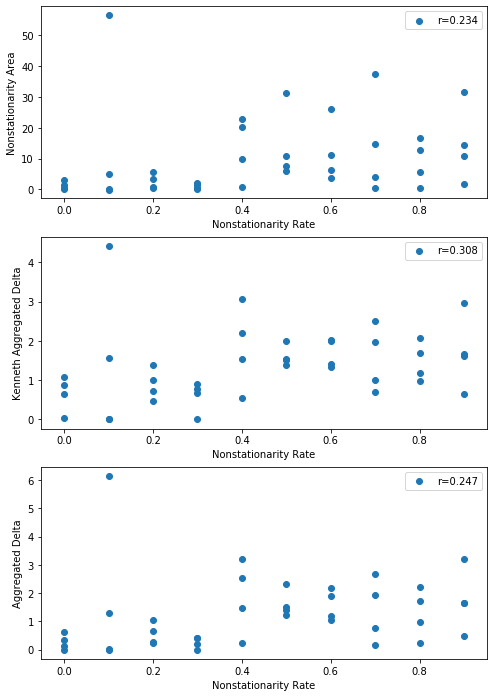

In [156]:
fig,ax = plt.subplots(3, figsize=(8,12))
ax[0].scatter(table[:,0], np.sum(table[:,11:21] - table[:,21:], axis=1),label=f"r={np.corrcoef(table[:,0], np.sum(table[:,11:21] - table[:,21:],axis=1))[0,1]:.3f}")
ax[0].set_xlabel("Nonstationarity Rate")
ax[0].set_ylabel("Nonstationarity Area")
ax[0].legend()
ax[1].scatter(table[:,0], deltas_kagg,label=f"r={np.corrcoef(table[:,0],deltas_kagg)[0,1]:.3f}")
ax[1].set_xlabel("Nonstationarity Rate")
ax[1].set_ylabel("Kenneth Aggregated Delta")
ax[1].legend()
ax[2].scatter(table[:,0], deltas_agg,label=f"r={np.corrcoef(table[:,0],deltas_agg)[0,1]:.3f}")
ax[2].set_xlabel("Nonstationarity Rate")
ax[2].set_ylabel("Aggregated Delta")
ax[2].legend()
plt.show()

In [16]:
np.corrcoef(table[:,0],table[:,1])

array([[1.        , 0.83054646],
       [0.83054646, 1.        ]])

In [3]:
data = driverVdelta(25, thetaS, 2, 1)

NameError: name 'thetaS' is not defined

In [ ]:
weightDropoff = np.exp(-data[:,2]*0.25)
# weightDropoff = (1-datums[:,2])**(1/10)
pcc = np.corrcoef(data[:,0],weightDropoff)[0,1]

In [ ]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], weightDropoff)
ax.set_ylabel("Drop in weight over 25% of series")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

In [ ]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], data[:,2])
ax.set_ylabel("Optimal Delta")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

In [ ]:
# fix, ax = plt.subplots(1)
# ax.imshow(landNS[1:,1:,2])